## Covariance Cleaning Methods and Markowitz Portfolio

Our initial dataset contained approximately 182 million rows, with data recorded every minute. Since the goal is to compute rolling  portfolio optimization in a 60 minute window, we aggregated the data by minute using the `groupby` function in Pandas. As a result, we reduced the dataset to about 1.5 million rows, which is manageable for processing.

The dataset used is located in the `data` folder. However, to make everyhting work, some data files need to be downloaded:

1. Download the SP100 data for the period 2004-2008 from the following [link](https://drive.switch.ch/index.php/s/0X3Je6DauQRzD2r) and insert it into the `data` folder. Remember to decompress the folder `sp100_2004-8`.
2. Download all folders from the [link](https://drive.google.com/drive/folders/1JWhsf7jwS9RcTxgKnULsMfPRPByhF7GO?usp=sharing) and place them in the `data` folder.


In [1]:
from utils import *
import pandas as pd
import numpy as np
from numpy import linalg as LA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
from bahc import BAHC
import os

# Introduction

This Jupyter Notebook provides an overview of our project and the steps taken to achieve its objectives.

The primary goal of this project was to denoise covariance matrices. Studies in Random Matrix Theory (RMT) suggest that over 90% of the data in such matrices is noise. This high noise level leads to an underestimation of risk during portfolio optimization. 

To address this issue, we explored covariance matrix denoising techniques to achieve more accurate optimization solution for the Markowitz portfolio and more precise risk estimation both in and out-of-sample.

We evaluated the following three approaches:
1. Covariance Matrix with No Filter.
2. RMT-Eigenvalue Clipping.
3. The BAHC (Bootstrap Average linkage Hierarchical Clustering) method.


In [2]:
data = pd.read_parquet("data/clean_full_bbo_data.parquet")
data.head()

,time,Stock,bid_vwa,ask_vwa,vwap_mid_price
0,2008-04-23 14:26,PG.N,67.096526,67.110915,67.103720
1,2008-08-07 13:28,C.N,18.899127,18.911981,18.905554
2,2008-08-25 15:49,RTN.N,59.832404,59.834434,59.833419
3,2008-11-25 10:38,RTN.N,46.339335,46.404700,46.372018
4,2008-01-15 12:58,TWX.N,15.950000,15.960000,15.955000


In [3]:
data['time'] = pd.to_datetime(data['time'])

# Sort the DataFrame
data = data.sort_values(by=["time", "Stock"])

# Create the pivot table
pivot_table = data.pivot(index="time", columns="Stock", values="vwap_mid_price")

pivot_table = pivot_table.sort_index(axis=1)

# Forward & Backward fill
pivot_table = pivot_table.fillna(method='bfill', axis=0)
pivot_table = pivot_table.fillna(method='ffill', axis=0)

/var/folders/cg/lm106ggx1z59db7x0_wgfghm0000gn/T/ipykernel_29235/3679780221.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot_table = pivot_table.fillna(method='bfill', axis=0)
/var/folders/cg/lm106ggx1z59db7x0_wgfghm0000gn/T/ipykernel_29235/3679780221.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot_table = pivot_table.fillna(method='ffill', axis=0)


In [4]:
# Calculate returns
returns = pivot_table.pct_change() # simple linear returns
log_rets = np.log(1+returns) # log returns
log_rets.head()

Stock,C.N,EMC.N,HPQ.N,MDT.N,MO.N,NKE.N,PG.N,RTN.N,SO.N,TWX.N,WFC.N
time,,,,,,,,,,,
2008-01-02 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02 09:31:00,0.000912,-0.000963,0.001764,0.000133,-0.000460,0.000000,0.000000,0.000000,-0.003609,0.000811,-0.000938
2008-01-02 09:32:00,0.003021,0.000937,0.000208,0.002860,0.002817,-0.000876,-0.003091,0.001105,0.000964,0.001274,-0.000611
2008-01-02 09:33:00,-0.003202,0.003830,0.000126,0.000219,-0.002206,-0.000435,-0.002158,0.001351,0.001741,0.000458,-0.001478
2008-01-02 09:34:00,-0.003452,-0.001278,-0.000035,0.000995,-0.001033,-0.002415,-0.001420,-0.001554,0.000100,0.000088,0.000796


In [5]:
# Check if there are NaNs
if log_rets.isnull().values.any():
    print("There are NaN values in the pivot table.")
else:
    print("There are no NaN values in the pivot table.")
log_rets = log_rets.fillna(0)
log_rets.head()

There are NaN values in the pivot table.


Stock,C.N,EMC.N,HPQ.N,MDT.N,MO.N,NKE.N,PG.N,RTN.N,SO.N,TWX.N,WFC.N
time,,,,,,,,,,,
2008-01-02 09:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-02 09:31:00,0.000912,-0.000963,0.001764,0.000133,-0.000460,0.000000,0.000000,0.000000,-0.003609,0.000811,-0.000938
2008-01-02 09:32:00,0.003021,0.000937,0.000208,0.002860,0.002817,-0.000876,-0.003091,0.001105,0.000964,0.001274,-0.000611
2008-01-02 09:33:00,-0.003202,0.003830,0.000126,0.000219,-0.002206,-0.000435,-0.002158,0.001351,0.001741,0.000458,-0.001478
2008-01-02 09:34:00,-0.003452,-0.001278,-0.000035,0.000995,-0.001033,-0.002415,-0.001420,-0.001554,0.000100,0.000088,0.000796


## Plot Moving Averages

First, we plotted the moving average for the 11 selected stocks.

We focused on the last year of data (2008) and selected stocks that had complete daily data for the entire year after analyzing the dataset.


In [6]:
means_rolling_data= []
T_in = 60                      
start_period_in_sample = 0   
end_period_in_sample = len(data)
dT = 5
ts = np.arange(start_period_in_sample, end_period_in_sample ,dT)    # 16031 is the index st the last date is 29/02/2008
for t0 in ts:
  t1 = t0 + T_in
  log_rets_cut = log_rets.iloc[t0:t1]
  
  # Compute means, covariance and correlation
  mean_values_rolling = log_rets_cut.mean()
  
  # Append the results to the lists
  means_rolling_data.append(mean_values_rolling)

In [7]:
# Ensure the indices are within bounds
valid_indices = ts[ts + T_in < len(log_rets)]
means_rolling_data_df = pd.DataFrame(means_rolling_data[:len(valid_indices)], index=log_rets.index[valid_indices + T_in], columns=pivot_table.columns)
means_rolling_data_df.tail(-5000)

Stock,C.N,EMC.N,HPQ.N,MDT.N,MO.N,NKE.N,PG.N,RTN.N,SO.N,TWX.N,WFC.N
time,,,,,,,,,,,
2008-04-04 10:06:00,-0.000266,-0.000217,-0.000182,0.000056,-0.000032,-0.000091,0.000008,0.000011,0.000139,0.000034,0.000003
2008-04-04 10:11:00,-0.000405,-0.000281,-0.000236,0.000036,-0.000080,-0.000147,0.000007,0.000008,0.000131,-0.000078,-0.000108
2008-04-04 10:16:00,-0.000391,-0.000249,-0.000230,0.000054,-0.000070,-0.000097,0.000015,0.000048,0.000131,-0.000019,-0.000089
2008-04-04 10:21:00,-0.000350,-0.000241,-0.000212,0.000085,-0.000081,-0.000079,0.000022,0.000070,0.000135,-0.000026,-0.000054
2008-04-04 10:26:00,-0.000430,-0.000252,-0.000233,0.000074,-0.000080,-0.000125,0.000010,0.000040,0.000166,-0.000083,-0.000081
...,...,...,...,...,...,...,...,...,...,...,...
2008-12-31 15:36:00,0.000285,0.000046,-0.000063,0.000036,0.000053,0.000114,0.000046,-0.000005,0.000026,0.000100,0.000378
2008-12-31 15:41:00,0.000116,0.000011,-0.000077,0.000023,0.000014,0.000096,0.000057,0.000030,0.000039,0.000058,0.000386
2008-12-31 15:46:00,-0.000088,-0.000020,-0.000138,0.000020,-0.000024,0.000033,0.000014,-0.000021,0.000029,0.000012,0.000302


/Users/valentinaolaritei/Desktop/3_SEMESTER/FIN-525 Project/utils.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot_table = pivot_table.fillna(method='bfill', axis=0).fillna(method='ffill', axis=0)


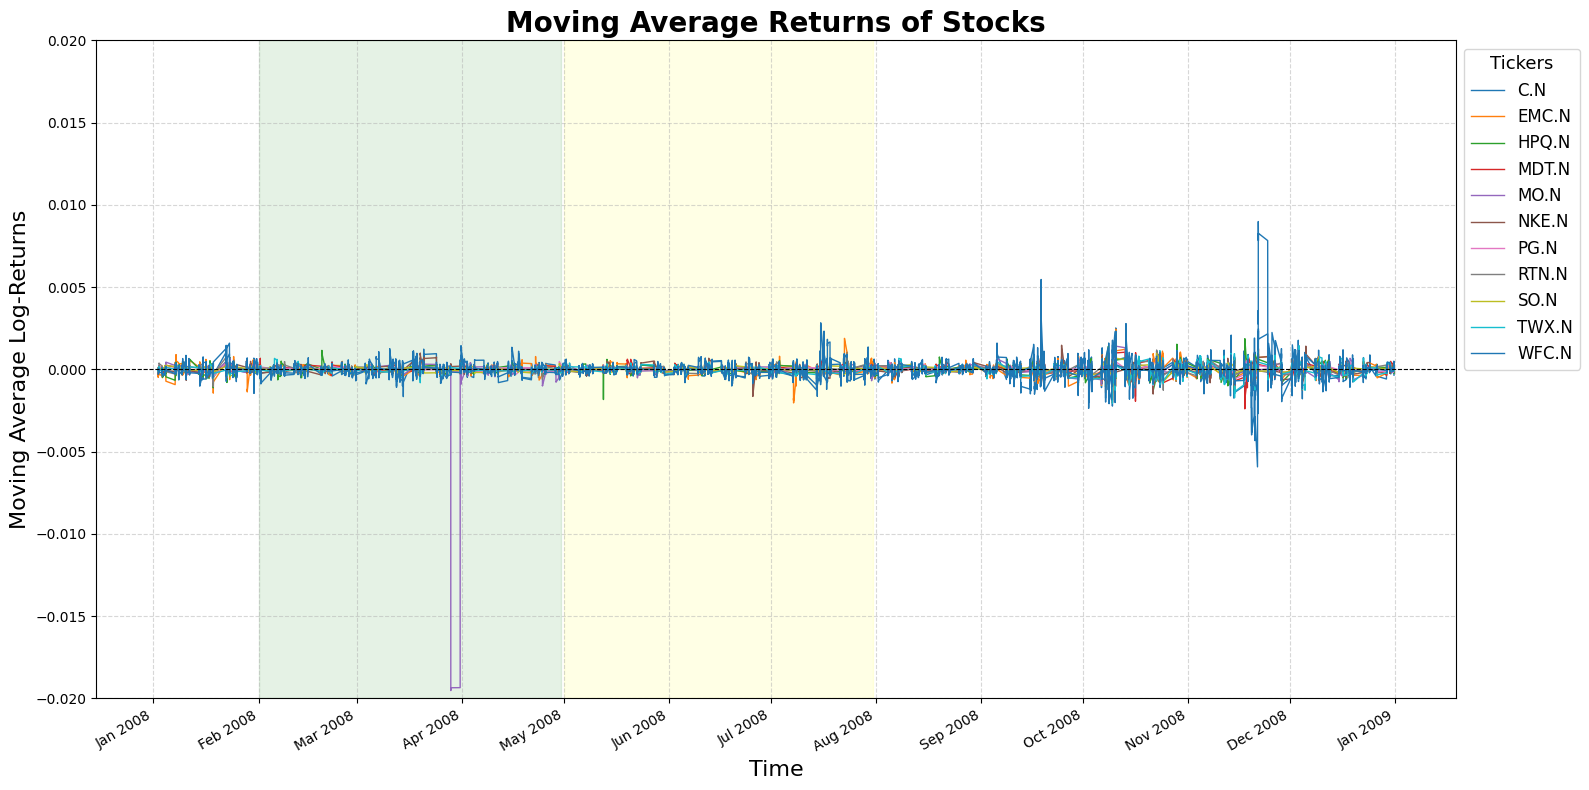

In [8]:
# Plot moving average returns on a 5-minute interval for 60-minute rolling window
plot_moving_average_returns(
    parquet_file='data/clean_full_bbo_data.parquet',
    T_in=60,
    dT=5,
    in_sample_period=('2008-02-01', '2008-04-30'),
    out_sample_period=('2008-05-01', '2008-07-31')
)

## Plot risk for Covariance method with No Filter


In this method, we computed the out-of-sample variance using the formula 
$$ \sigma_{out}^2 = w^{T} \Sigma_{out} w $$
where, 
$$ w^* = \frac{\Sigma^{-1} \cdot \mathbf{1}}{\mathbf{1}^T \Sigma^{-1} \mathbf{1}}$$

It is possible to observe that out-of-sample, as expected, the variance is higher than the in-sample one.

### In-Sample

In [9]:
T_in = 60                       # lenght of the rolling window in minutes
start_period_in_sample = 8151   # 1st Febraury 2008
end_period_in_sample = 32417    # last day of April 2008
dT = 5
t0s = np.arange(start_period_in_sample, end_period_in_sample ,dT)    # 16031 is the index st the last date is 29/02/2008
t0s

array([ 8151,  8156,  8161, ..., 32406, 32411, 32416], shape=(4854,))

In [10]:
riks_in_sample = []
weights = []
means_in_sample = []
# Rolling window
for t0 in t0s:
  
  t1 = t0 + T_in
  log_rets_cut = log_rets.iloc[t0:t1]
  
  # Compute means, covariance and correlation
  mean_values = log_rets_cut.mean()
  covariance_matrix = log_rets_cut.cov()
  
  # Compute the GMV weights
  weights_GVM = compute_weights_GVM(covariance_matrix)
  
  # compute risk in sample
  risk = np.dot(weights_GVM.T, np.dot(covariance_matrix, weights_GVM))
  
  # Append the results to the lists
  means_in_sample.append(mean_values)
  riks_in_sample.append(risk)
  weights.append(weights_GVM)

In [11]:
# Create DataFrame for means_in_sample
moving_avg_in_sample = pd.DataFrame(means_in_sample, index=log_rets.index[t0s+T_in], columns=pivot_table.columns)

# Create DataFrame for risks_in_sample
risks_df_in_sample = pd.DataFrame(riks_in_sample, index=log_rets.index[t0s+T_in], columns=['Risk'])

# Create DataFrame for weights
weights_df = pd.DataFrame(weights, index=log_rets.index[t0s+T_in], columns=pivot_table.columns)


In [12]:
weights_df.head()

Stock,C.N,EMC.N,HPQ.N,MDT.N,MO.N,NKE.N,PG.N,RTN.N,SO.N,TWX.N,WFC.N
time,,,,,,,,,,,
2008-02-01 09:30:00,-0.283125,0.094916,-0.228489,0.344422,0.333485,0.077326,0.234195,0.242347,0.092655,0.123783,-0.031515
2008-02-01 09:35:00,-0.285985,0.119753,-0.229875,0.427792,0.224376,0.023153,0.318659,0.283065,0.093964,0.043184,-0.018086
2008-02-01 09:40:00,-0.175625,0.068487,-0.174937,0.139305,0.341044,0.144504,0.283653,0.173302,0.144686,-0.000699,0.056280
2008-02-01 09:45:00,-0.166044,0.076587,-0.168531,0.091932,0.317723,0.129980,0.332181,0.167686,0.171520,-0.003405,0.050370
2008-02-01 09:50:00,-0.130619,0.052118,-0.166311,0.098280,0.336717,0.165337,0.251066,0.188424,0.166324,-0.015583,0.054248


In [13]:
risks_df_in_sample.head()

,Risk
time,
2008-02-01 09:30:00,2.427100e-07
2008-02-01 09:35:00,2.828104e-07
2008-02-01 09:40:00,3.619740e-07
2008-02-01 09:45:00,3.666299e-07
2008-02-01 09:50:00,3.678620e-07


### Out-of_Sample

In [14]:
T_in = 60  # lenght of the rolling window in minutes
start_period_out_sample = end_period_in_sample
end_period_out_sample = start_period_out_sample + (end_period_in_sample - start_period_in_sample) # keep same length as in-sample
t0s_out_sample = np.arange(start_period_out_sample, end_period_out_sample ,dT)    # 16031 is the index st the last date is 29/02/2008
t0s_out_sample

array([32417, 32422, 32427, ..., 56672, 56677, 56682], shape=(4854,))

In [15]:
riks_out_sample = []
moving_average_out_sample = []

# Rolling window

for t1 in enumerate(t0s_out_sample):
  
  t2 = t1[1] + T_in
  log_rets_cut = log_rets.iloc[t1[1]:t2]
  
  # Compute means, covariance and correlation
  mean_values = log_rets_cut.mean()
  covariance_matrix = log_rets_cut.cov()
  
  # compute risk in sample
  risk = np.dot(weights[t1[0]].T, np.dot(covariance_matrix, weights[t1[0]]))
  
  # Append the results to the lists
  moving_average_out_sample.append(mean_values)
  riks_out_sample.append(risk)
  

In [16]:
# Create DataFrame for means_in_sample
moving_avg_out_sample = pd.DataFrame(moving_average_out_sample, index=log_rets.index[t0s_out_sample+T_in], columns=pivot_table.columns)

# Create DataFrame for risks_in_sample
risks_df_out_sample = pd.DataFrame(riks_out_sample, index=log_rets.index[t0s_out_sample+T_in], columns=['Risk'])

In [17]:
risks_df_out_sample.head()

,Risk
time,
2008-05-01 09:54:00,3.265855e-07
2008-05-01 09:59:00,3.553322e-07
2008-05-01 10:04:00,2.275061e-07
2008-05-01 10:09:00,2.123848e-07
2008-05-01 10:14:00,1.712682e-07


### Export into CSV

In [18]:
folder_name = "data/covariance_data"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'data/covariance_data' already exists.


In [19]:
risks_df_in_sample.to_csv(f'{folder_name}/risks_in_samples.csv')
risks_df_out_sample.to_csv(f'{folder_name}/risks_out_sample.csv')
weights_df.to_csv(f'{folder_name}/weights_df.csv')
moving_avg_in_sample.to_csv(f'{folder_name}/moving_avg_in_sample.csv')
moving_avg_out_sample.to_csv(f'{folder_name}/moving_avg_out_sample.csv')

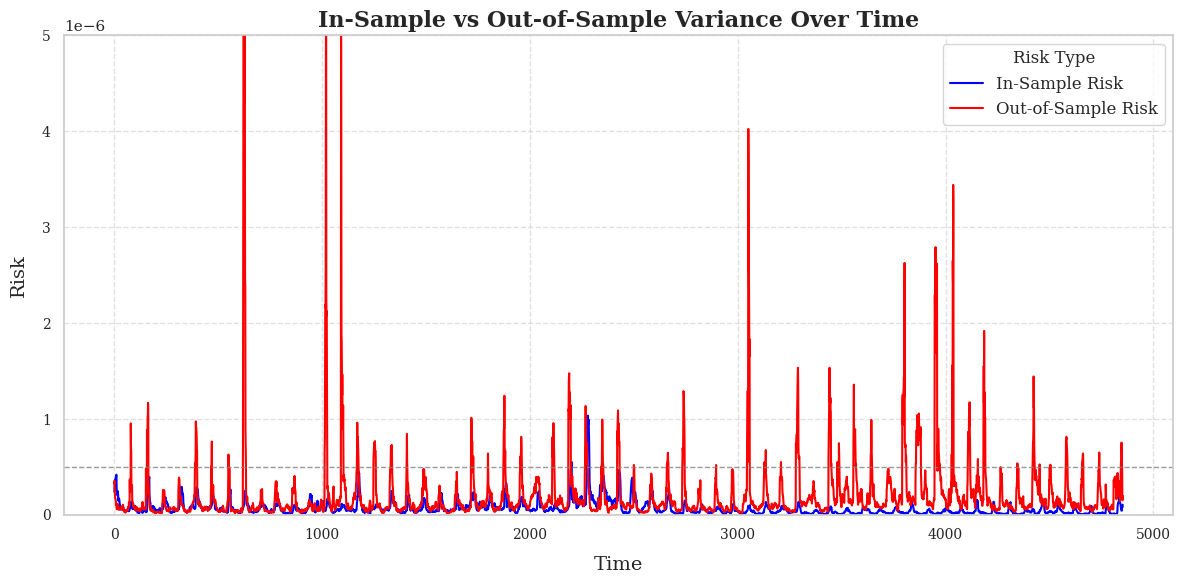

In [20]:
cov_in_sample = pd.read_csv('data/covariance_data/risks_in_sample.csv')
cov_out_sample = pd.read_csv('data/covariance_data/risks_out_sample.csv')
plot_two_risks(cov_in_sample, cov_out_sample)

## Plot risk for Correlation Clipping

In this analysis, we applied the **Marchenko-Pastour theorem** from Random Matrix Theory (RMT). Specifically, we set all eigenvalues greater than or equal to $ \lambda_+ $ to:
$$
\lambda_+ = \sigma^2 (1 - \sqrt{q})^2
$$
where $ q = \frac{N}{T} $ is the ratio of assets $ N $ to observations $ T $, and $ \sigma^2 $ is the variance. The remaining eigenvalues were set to a constant $ \delta $. More details are provided in the report.

It is also observed that the estimated out-of-sample variance is higher than the in-sample variance.


### In-Sample

In [21]:
riks_in_sample_clipped = []
weights_clipped = []
means_in_sample_clipped = []


for t0 in t0s:
  
  t1 = t0 + T_in
  log_rets_cut = log_rets.iloc[t0:t1]
  
  # Compute means, std and correlation
  mean_values = log_rets_cut.mean()
  correlation_matrix = log_rets_cut.corr()
  std_matrix = log_rets_cut.std()
  
  # variables for the eigenvalue clipping
  T, N = log_rets_cut.shape
  q = N / T
  lambda_plus = (1+np.sqrt(q))**2
  eigenvalues, eigenvectors = LA.eig(correlation_matrix)
  
  # Clean Covariance Matrix
  correlation_matrix_clipped = eigenvalue_clipping(eigenvalues, eigenvectors, lambda_plus)
  # correlation_matrix_clipped = pd.DataFrame(correlation_matrix_clipped, index=log_rets_cut.columns, columns=log_rets_cut.columns)
  
  cov_matrix = np.diag(std_matrix) @ correlation_matrix_clipped @ np.diag(std_matrix)
  covariance_matrix_clipped = pd.DataFrame(cov_matrix, index=log_rets_cut.columns, columns=log_rets_cut.columns)

  # print(covariance_matrix_clipped)
  
  # Compute the GMV weights
  weights_GVM_clipped = compute_weights_GVM(covariance_matrix_clipped)
  
  # compute risk in sample
  risk_clipped = np.dot(weights_GVM_clipped.T, np.dot(covariance_matrix_clipped, weights_GVM_clipped))
  
  # Append results
  means_in_sample_clipped.append(mean_values)
  riks_in_sample_clipped.append(risk_clipped)
  weights_clipped.append(weights_GVM_clipped)

In [22]:
# Create DataFrames

moving_avg_in_sample = pd.DataFrame(means_in_sample_clipped, index=log_rets.index[t0s+T_in], columns=pivot_table.columns)
risks_df_in_sample = pd.DataFrame(riks_in_sample_clipped, index=log_rets.index[t0s+T_in], columns=['Risk'])
weights_df = pd.DataFrame(weights_clipped, index=log_rets.index[t0s+T_in], columns=pivot_table.columns)


In [23]:
weights_df.head()


Stock,C.N,EMC.N,HPQ.N,MDT.N,MO.N,NKE.N,PG.N,RTN.N,SO.N,TWX.N,WFC.N
time,,,,,,,,,,,
2008-02-01 09:30:00,0.264207,0.047784,0.046133,0.131919,0.209084,0.120032,0.131687,0.089951,-0.178591,0.097899,0.039894
2008-02-01 09:35:00,-0.034226,0.071962,0.092759,0.096233,0.457921,0.029900,-0.090081,0.333657,0.039498,0.007390,-0.005013
2008-02-01 09:40:00,0.115094,0.081218,0.014650,0.105948,0.191754,0.000915,0.110378,0.201142,0.144584,0.031744,0.002573
2008-02-01 09:45:00,-0.330526,0.187632,0.222265,0.922746,0.142341,-0.665772,0.277880,0.072882,0.041911,0.130970,-0.002330
2008-02-01 09:50:00,0.425417,-0.322353,-0.658044,0.464536,-0.942823,1.989990,-0.007067,0.256944,0.203890,-0.354593,-0.055898


In [24]:
risks_df_in_sample.head()

,Risk
time,
2008-02-01 09:30:00,1.104692e-07
2008-02-01 09:35:00,1.132002e-07
2008-02-01 09:40:00,1.483845e-07
2008-02-01 09:45:00,3.358627e-07
2008-02-01 09:50:00,-3.203268e-07


In [25]:
riks_out_sample_clipped = []
moving_average_out_sample_clipped = []

for t1 in enumerate(t0s_out_sample):
  
  t2 = t1[1] + T_in
  log_rets_cut = log_rets.iloc[t1[1]:t2]
  
  # Compute means & covariance
  mean_values = log_rets_cut.mean()
  covariance_matrix = log_rets_cut.cov()
  
  # compute risk in sample
  risk = np.dot(weights_clipped[t1[0]].T, np.dot(covariance_matrix, weights_clipped[t1[0]]))
  
  # Append the results to the lists
  moving_average_out_sample_clipped.append(mean_values)
  riks_out_sample_clipped.append(risk)
  

In [26]:
# Create DataFrames
moving_avg_out_sample_clipped = pd.DataFrame(moving_average_out_sample_clipped, columns=pivot_table.columns)
risks_df_out_sample_clipped = pd.DataFrame(riks_out_sample_clipped, columns=['Risk'])


In [27]:
risks_df_out_sample_clipped.head()

,Risk
0,4.859168e-07
1,4.941345e-07
2,1.949967e-07
3,2.231772e-06
4,1.212733e-05


In [28]:
risks_df_in_sample.head(3)

,Risk
time,
2008-02-01 09:30:00,1.104692e-07
2008-02-01 09:35:00,1.132002e-07
2008-02-01 09:40:00,1.483845e-07


### Export Data into CSV

In [29]:
folder_name = "data/correlation_data"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'data/correlation_data' already exists.


In [30]:
risks_df_in_sample.to_csv(f'{folder_name}/risks_in_sample.csv')
risks_df_out_sample_clipped.to_csv(f'{folder_name}/risk_out_sample.csv')
weights_df.to_csv(f'{folder_name}/weights.csv')
moving_avg_in_sample.to_csv(f'{folder_name}/moving_avg_in_sample.csv')
moving_avg_out_sample_clipped.to_csv(f'{folder_name}/moving_avg_out_sample.csv')

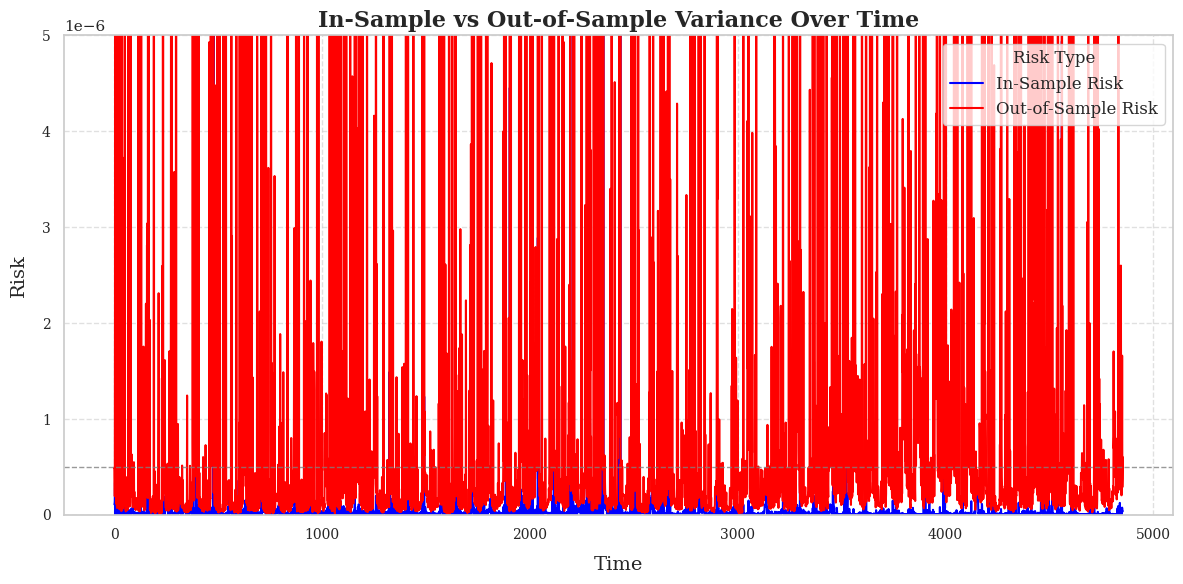

In [31]:
corr_in_sample = pd.read_csv('data/correlation_data/risks_in_sample.csv')
corr_out_sample = pd.read_csv('data/correlation_data/risk_out_sample.csv')
plot_two_risks(corr_in_sample, corr_out_sample)

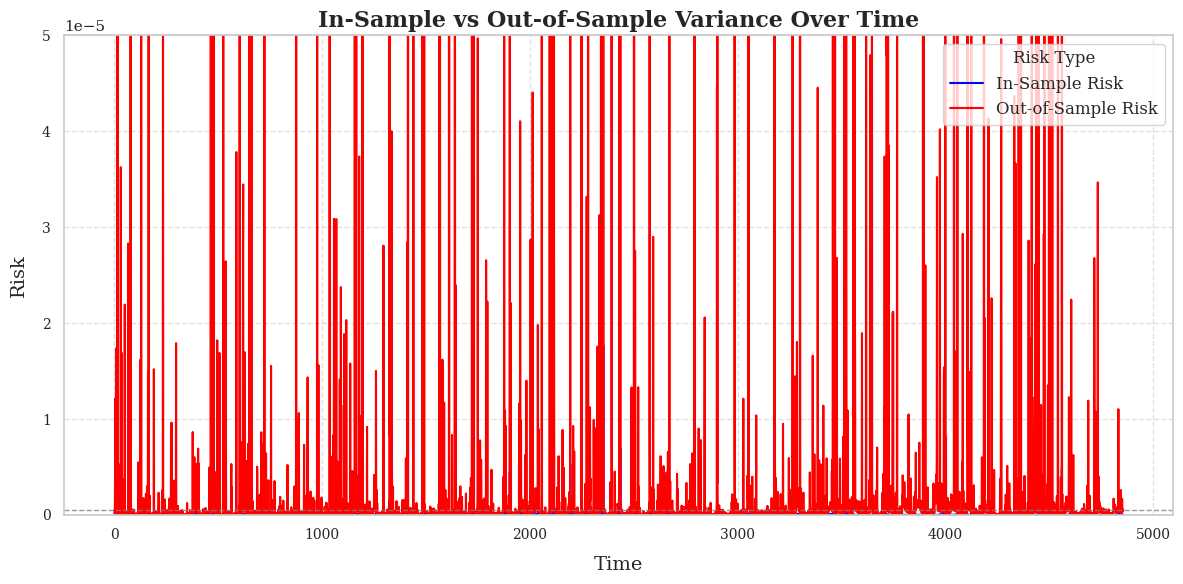

In [32]:
plot_two_risks_clipped(corr_in_sample, corr_out_sample)

## Plot risk for BAHC

In this study, we employed the Bootstrap Hierarchical (BAHC) method to estimate the covariance matrix. Using this matrix, we calculated optimal portfolio weights via the formula:

$$ w^* = \frac{\Sigma^{-1}_{BAHC} \cdot \mathbf{1}}{\mathbf{1}^T \Sigma^{-1}_{BAHC} \mathbf{1}}$$

We then computed both in-sample and out-of-sample variances. As anticipated, the out-of-sample variance exceeded the in-sample variance, revealing potential model limitations in portfolio weight estimation.

### In-Sample

In [33]:
riks_in_sample = []
weights = []
means_in_sample = []

for t0 in t0s:
  
  t1 = t0 + T_in
  log_rets_cut = log_rets.iloc[t0:t1]
  
  # Compute means, std and correlation
  mean_values = log_rets_cut.mean()
  
  # center the data to execute the BAHC
  log_rets_cut_centered = StandardScaler(with_mean=True, with_std=False).fit_transform(log_rets_cut)
  bahc_log_rets = BAHC(log_rets_cut_centered.T, K=1, Nboot=100, method='near', filter_type='covariance')
  bahc_covariance_matrix_array = bahc_log_rets.filter_matrix()

  # convert the array to a dataframe
  bahc_covariance_matrix = pd.DataFrame(bahc_covariance_matrix_array, index=log_rets_cut.columns, columns=log_rets_cut.columns)
  
  weights_GVM_list = compute_weights_GVM(bahc_covariance_matrix_array)
  weights_GVM = np.array(weights_GVM_list)
  
  
  # compute the risk
  risk = np.dot(weights_GVM.T, np.dot(bahc_covariance_matrix, weights_GVM))
  
  # Append the results to the lists
  means_in_sample.append(mean_values)
  riks_in_sample.append(risk)
  weights.append(weights_GVM)

  

In [34]:
# Create DataFrames
moving_avg_in_sample_bahc = pd.DataFrame(means_in_sample, index=log_rets.index[t0s+T_in], columns=pivot_table.columns)
risks_df_in_sample_bahc = pd.DataFrame(riks_in_sample, index=log_rets.index[t0s+T_in], columns=['Risk'])
weights_bahc = pd.DataFrame(weights, index=log_rets.index[t0s+T_in], columns=pivot_table.columns)

In [35]:
risks_df_in_sample_bahc

,Risk
time,
2008-02-01 09:30:00,2.840031e-07
2008-02-01 09:35:00,3.453382e-07
2008-02-01 09:40:00,3.821611e-07
2008-02-01 09:45:00,3.851230e-07
2008-02-01 09:50:00,3.741022e-07
...,...
2008-05-01 09:33:00,1.065485e-07
2008-05-01 09:38:00,1.167293e-07
2008-05-01 09:43:00,9.731867e-08


In [36]:
weights_bahc 

Stock,C.N,EMC.N,HPQ.N,MDT.N,MO.N,NKE.N,PG.N,RTN.N,SO.N,TWX.N,WFC.N
time,,,,,,,,,,,
2008-02-01 09:30:00,-0.211129,-0.025077,-0.161405,0.443137,0.279451,0.149396,0.189508,0.150403,0.103953,0.138455,-0.056691
2008-02-01 09:35:00,-0.178957,0.021290,-0.052538,0.303534,0.195788,0.091481,0.283453,0.207122,0.202402,-0.055260,-0.018315
2008-02-01 09:40:00,-0.148341,0.042315,-0.005171,0.169518,0.225741,0.094325,0.306406,0.211252,0.183488,-0.070862,-0.008672
2008-02-01 09:45:00,-0.135231,0.044120,-0.021385,0.164391,0.213428,0.083782,0.304286,0.220602,0.192650,-0.060088,-0.006556
2008-02-01 09:50:00,-0.121984,0.051843,-0.007387,0.159687,0.216930,0.079170,0.286112,0.219875,0.191898,-0.061238,-0.014905
...,...,...,...,...,...,...,...,...,...,...,...
2008-05-01 09:33:00,0.502349,-0.050205,-0.029296,0.197471,0.013788,0.031286,0.081692,0.211052,-0.033600,0.089715,-0.014253
2008-05-01 09:38:00,0.440841,-0.049380,-0.033619,0.248955,0.005453,0.061765,0.084841,0.245534,-0.034440,0.040279,-0.010226
2008-05-01 09:43:00,0.288514,-0.043690,-0.001830,0.246662,-0.006354,0.112490,0.062908,0.279363,-0.017772,0.035823,0.043888


#### Out-of-Sample

In [38]:
riks_out_sample = []
moving_average_out_sample = []

for t1 in enumerate(t0s_out_sample):
  
  t2 = t1[1] + T_in
  log_rets_cut = log_rets.iloc[t1[1]:t2]
  
  # Compute means, covariance and correlation
  mean_values = log_rets_cut.mean()
  covariance_matrix = log_rets_cut.cov()
  
  # compute risk in sample
  risk = np.dot(weights[t1[0]].T, np.dot(covariance_matrix, weights[t1[0]]))
  
  # Append the results to the lists
  moving_average_out_sample.append(mean_values)
  riks_out_sample.append(risk)

In [39]:
# Create DataFrame for means_in_sample
moving_avg_out_sample_bahc = pd.DataFrame(moving_average_out_sample, index=log_rets.index[t0s_out_sample+T_in], columns=pivot_table.columns)

# Create DataFrame for risks_in_sample
risks_df_out_sample_bahc = pd.DataFrame(riks_out_sample, index=log_rets.index[t0s_out_sample+T_in], columns=['Risk'])

In [40]:
risks_df_out_sample_bahc.head()

,Risk
time,
2008-05-01 09:54:00,2.306005e-07
2008-05-01 09:59:00,1.754345e-07
2008-05-01 10:04:00,1.863575e-07
2008-05-01 10:09:00,1.755491e-07
2008-05-01 10:14:00,1.536166e-07


In [41]:
risks_df_in_sample_bahc.head()

,Risk
time,
2008-02-01 09:30:00,2.840031e-07
2008-02-01 09:35:00,3.453382e-07
2008-02-01 09:40:00,3.821611e-07
2008-02-01 09:45:00,3.851230e-07
2008-02-01 09:50:00,3.741022e-07


### Export data into CSV

In [42]:
folder_name = "data/bahc"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'data/bahc' already exists.


In [43]:
risks_df_in_sample_bahc.to_csv(f'{folder_name}/risk_in_sample.csv')
risks_df_out_sample_bahc.to_csv(f'{folder_name}/risk_out_sample.csv')
weights_bahc.to_csv(f'{folder_name}/weights.csv')
moving_avg_in_sample_bahc.to_csv(f'{folder_name}/moving_avg_in_sample.csv')
moving_avg_out_sample_bahc.to_csv(f'{folder_name}/moving_avg_out_sample.csv')

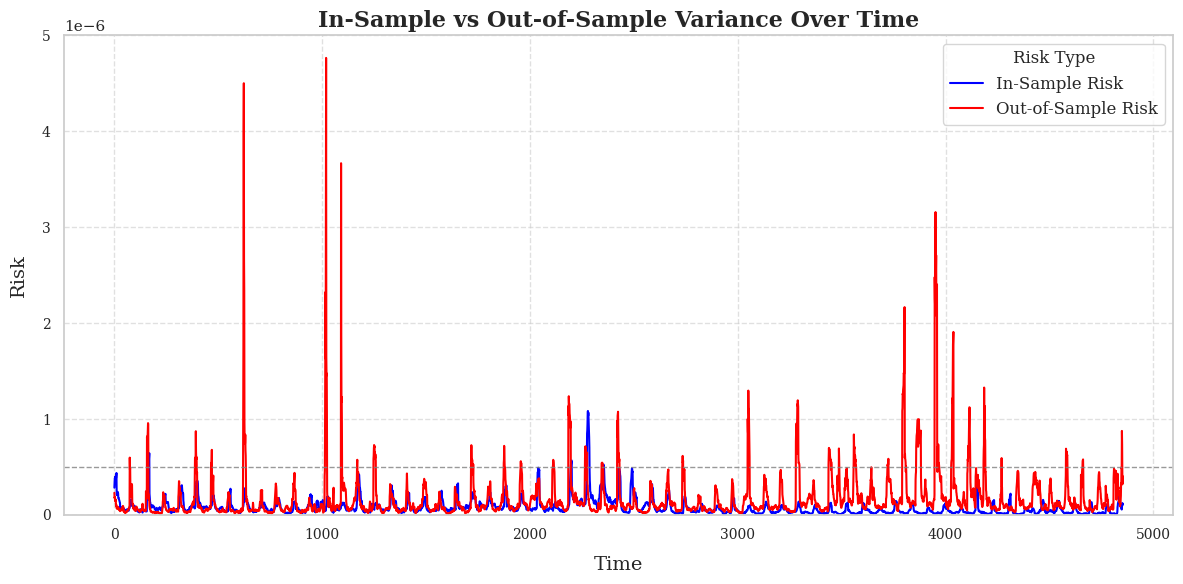

In [44]:
bahc_out_sample = pd.read_csv('data/bahc/risk_out_sample.csv')
bahc_in_sample = pd.read_csv('data/bahc/risk_in_sample.csv')
plot_two_risks(bahc_in_sample, bahc_out_sample)

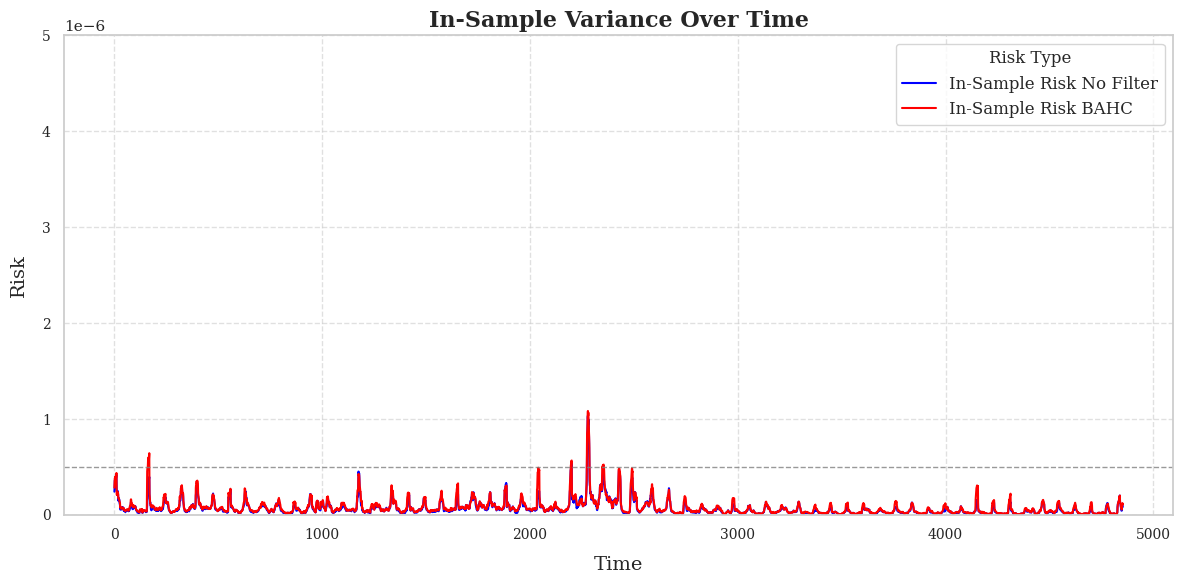

In [45]:
plot_two_risks_in(cov_in_sample,bahc_in_sample)

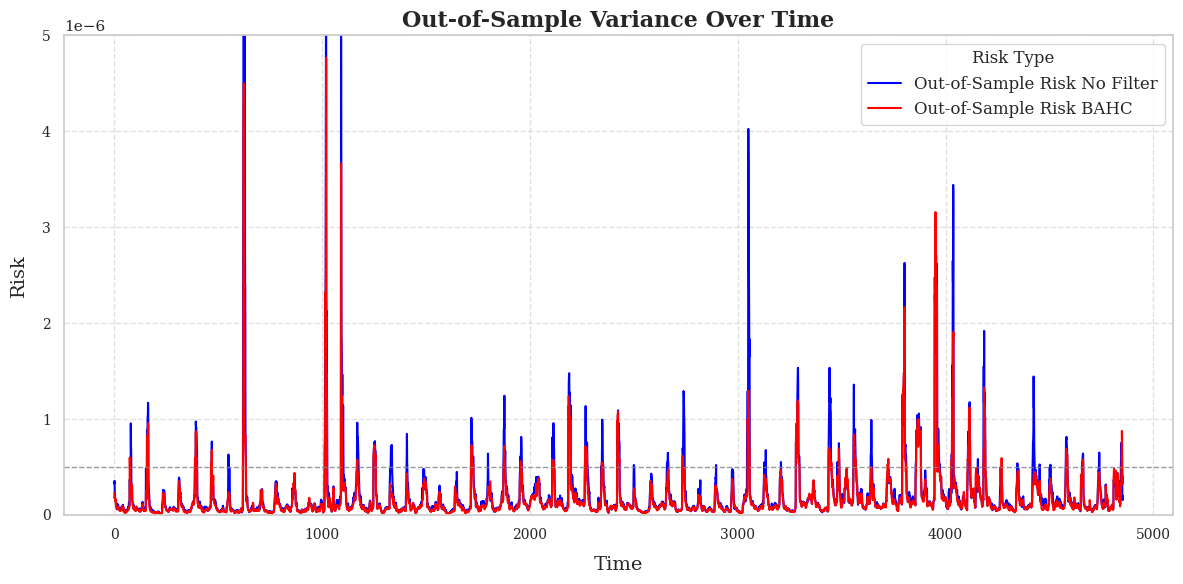

In [46]:
plot_two_risks_out(cov_out_sample,bahc_out_sample)